In [6]:
from __future__ import print_function
from __future__ import division

---
## 2. Stochastic Neighbor Embedding 

Stochastic Neighbor Embedding (SNE) starts by converting the
high-dimensional Euclidean distances between datapoints into conditional
probabilities that represent similarities.  The similarity of datapoint
\\(x\_j\\) to datapoint \\(x\_i\\) is the conditional probability,
\\(p\_{j|i}\\), that \\(x\_i\\) would pick \\(x\_j\\) as its neighbor if
neighbors were picked in proportion to their probability density under a
Gaussian centered at \\(x\_i\\).  For nearby datapoints, \\(p\_{j|i}\\) is
relatively high, whereas for widely separated datapoints, \\(p\_{j|i}\\)
will be almost infinitesimal (for reasonable values of the variance of the
Gaussian, \\(\sigma\_i\\)). Mathematically, the conditional probability
pjji is given by

\[
(1)
\]


where \\(\sigma\_i\\) is the variance of the Gaussian that is centered on
datapoint \\(x\_i\\).  The method for determining the value of
\\(\sigma\_i\\) is presented later in this section.  Because we are only
interested in modeling pairwise similarities, we set the value of
\\(p\_{i|i}\\) to zero.  For the low-dimensional counterparts \\(y\_i\\)
and \\(y\_j\\) of the high-dimensional datapoints \\(x\_i\\) and
\\(x\_j\\), it is possible to compute a similar conditional probability,
which we denote by \\(q\_{j|i}\\).  We set the variance of the Gaussian
that is employed in the computation of the conditional probabilities
\\(q\_{j|i}\\) to \\(\frac{1}{\sqrt{2}}\\). Hence, we model the similarity
of map point \\(y\_j\\) to map point \\(y\_i\\) by

\[
(1.5)
\] 

Again, since we are only interested in modeling pairwise similarities, we
set \\(q\_{i|i}=0\\).

If the map points \\(y\_i\\) and \\(y\_j\\) correctly model the similarity
between the high-dimensional datapoints \\(x\_i\\) and \\(x\_j\\), the
conditional probabilities \\(p\_{j|i}\\) and \\(q\_{j|i}\\) will be equal.
Motivated by this observation, SNE aims to find a low-dimensional data
representation that minimizes the mismatch between \\(p\_{j|i}\\) and
\\(q\_{j|i}\\).  A natural measure of the faithfulness with which
\\(q\_{j|i}\\) models \\(p\_{j|i}\\) is the Kullback-Leibler divergence
(which is in this case equal to the cross-entropy up to an additive
constant).  SNE minimizes the sum of Kullback-Leibler divergences over all
datapoints using a gradient descent method. The cost function C is given by

\[
(2)
\]

in which \\(P\_i\\) represents the conditional probability distribution
over all other datapoints given datapoint \\(x\_i\\), and \\(Q\_i\\)
represents the conditional probability distribution over all other map
points given map point yi. Because the Kullback-Leibler divergence is not
symmetric, different types of error in the pairwise distances in the
low-dimensional map are not weighted equally. In particular, there is a
large cost for using widely separated map points to represent nearby
datapoints (i.e., for using a small \\(q\_{j|i}\\) to model a large
\\(p\_{j|i}\\)), but there is only a small cost for using nearby map points
to represent widely separated datapoints. This small cost comes from
wasting some of the probability mass in the relevant Q distributions. In
other words, the SNE cost function focuses on retaining the local structure
of the data in the map (for reasonable values of the variance of the
Gaussian in the high-dimensional space, \\(\sigma\_i\\)).

The remaining parameter to be selected is the variance \\(\sigma\_i\\) of
the Gaussian that is centered over each high-dimensional datapoint,
\\(x\_i\\). It is not likely that there is a single value of
\\(\sigma\_i\\) that is optimal for all datapoints in the data set because
the density of the data is likely to vary.  In dense regions, a smaller
value of si is usually more appropriate than in sparser regions. Any
particular value of si induces a probability distribution, Pi, over all of
the other datapoints. This distribution has an entropy which increases as
si increases. SNE performs a binary search for the value of si that
produces a Pi with a fixed perplexity that is specified by the user.3 The
perplexity is defined as

\[
Perp(P\_i)=2^{H(P\_i)}
\]

where H(Pi) is the Shannon entropy of Pi measured in bits

\[
H(P_i)=-\sum\_jp\_{j|i}\log\_2P\{j|i},
\]

The perplexity can be interpreted as a smooth measure of the effective
number of neighbors. The performance of SNE is fairly robust to changes in
the perplexity, and typical values are between 5 and 50.

The minimization of the cost function in Equation 2 is performed using a
gradient descent method. The gradient has a surprisingly simple form

\[
\]

Physically, the gradient may be interpreted as the resultant force created
by a set of springs between the map point yi and all other map points y
j. All springs exert a force along the direction (yi􀀀y j).  The spring
between yi and y j repels or attracts the map points depending on whether
the distance between the two in the map is too small or too large to
represent the similarities between the two high-dimensional datapoints. The
force exerted by the spring between yi and y j is proportional to its
length, and also proportional to its stiffness, which is the mismatch (p
jji􀀀qjji+ pij j􀀀qij j) between the pairwise similarities of the data points
and the map points.

The gradient descent is initialized by sampling map points randomly from an
isotropic Gaussian with small variance that is centered around the
origin. In order to speed up the optimization and to avoid poor local
minima, a relatively large momentum term is added to the gradient. In other
words, the current gradient is added to an exponentially decaying sum of
previous gradients in order to determine the changes in the coordinates of
the map points at each iteration of the gradient search.  Mathematically,
the gradient update with a momentum term is given by

\[

\]

where Y (t) indicates the solution at iteration t, h indicates the learning
rate, and a(t) represents the momentum at iteration t.

In addition, in the early stages of the optimization, Gaussian noise is
added to the map points after each iteration. Gradually reducing the
variance of this noise performs a type of simulated annealing that helps
the optimization to escape from poor local minima in the cost function. If
the variance of the noise changes very slowly at the critical point at
which the global structure of the map starts to form, SNE tends to find
maps with a better global organization. Unfortunately, this requires
sensible choices of the initial amount of Gaussian noise and the rate at
which it decays.  Moreover, these choices interact with the amount of
momentum and the step size that are employed in the gradient descent. It is
therefore common to run the optimization several times on a data set to
find appropriate values for the parameters.4 In this respect, SNE is
inferior to methods that allow convex optimization and it would be useful
to find an optimization method that gives good results without requiring
the extra computation time and parameter choices introduced by the
simulated annealing.

---

## 3. t-Distributed Stochastic Neighbor Embedding
Section 2 discussed SNE as it was presented by Hinton and Roweis
(2002). Although SNE constructs reasonably good visualizations, it is
hampered by a cost function that is difficult to optimize and by a problem
we refer to as the “crowding problem”. In this section, we present a new
technique called “t-Distributed Stochastic Neighbor Embedding” or
“t-SNE” that aims to alleviate these problems.  The cost function used by
t-SNE differs from the one used by SNE in two ways: (1) it uses a
symmetrized version of the SNE cost function with simpler gradients that
was briefly introduced by Cook et al. (2007) and (2) it uses a Student-t
distribution rather than a Gaussian to compute the similarity between two
points in the low-dimensional space. t-SNE employs a heavy-tailed
distribution in the low-dimensional space to alleviate both the crowding
problem and the optimization problems of SNE.


In this section, we first discuss the symmetric version of SNE (Section
3.1). Subsequently, we discuss the crowding problem (Section 3.2), and the
use of heavy-tailed distributions to address this problem (Section 3.3). We
conclude the section by describing our approach to the optimization of the
t-SNE cost function (Section 3.4).

### 3.1 Symmetric SNE
As an alternative to minimizing the sum of the Kullback-Leibler divergences
between the conditional probabilities pjji and qjji, it is also possible to
minimize a single Kullback-Leibler divergence between a joint probability
distribution, P, in the high-dimensional space and a joint probability
distribution, Q, in the low-dimensional space

\[

\]

where again, we set pii and qii to zero. We refer to this type of SNE as
symmetric SNE, because it has the property that pi j = pji and qi j = qji
for 8i; j. In symmetric SNE, the pairwise similarities in
the low-dimensional map qi j are given by

\[
(3)
\]

The obvious way to define the pairwise similarities in the high-dimensional space pi j is

\[ 
\] 

but this causes problems when a high-dimensional datapoint xi is an outlier
(i.e., all pairwise distances kxi 􀀀x jk2 are large for xi). For such an
outlier, the values of pi j are extremely small for all j, so the location
of its low-dimensional map point yi has very little effect on the cost
function.  As a result, the position of the map point is not well
determined by the positions of the other map points. We circumvent this
problem by defining the joint probabilities pi j in the high-dimensional
space to be the symmetrized conditional probabilities, that is, we set pi j
= pjji+pij j 2n . This ensures that åj pi j > 1 2n for all datapoints xi,
as a result of which each datapoint xi makes a significant contribution to
the cost function. In the low-dimensional space, symmetric SNE simply uses
Equation 3.  The main advantage of the symmetric version of SNE is the
simpler form of its gradient, which is faster to compute. The gradient of
symmetric SNE is fairly similar to that of asymmetric SNE, and is given by

\[
\]

In preliminary experiments, we observed that symmetric SNE seems to produce maps that are just
as good as asymmetric SNE, and sometimes even a little better.

### 3.2 The Crowding Problem

Consider a set of datapoints that lie on a two-dimensional curved manifold
which is approximately linear on a small scale, and which is embedded
within a higher-dimensional space. It is possible to model the small
pairwise distances between datapoints fairly well in a two-dimensional map,
which is often illustrated on toy examples such as the “Swiss roll” data
set. Now suppose that the manifold has ten intrinsic dimensions5 and is
embedded within a space of much higher dimensionality.  There are several
reasons why the pairwise distances in a two-dimensional map cannot
faithfully model distances between points on the ten-dimensional
manifold. For instance, in ten dimensions, it is possible to have 11
datapoints that are mutually equidistant and there is no way to model this
faithfully in a two-dimensional map. A related problem is the very
different distribution of pairwise distances in the two spaces. The volume
of a sphere centered on datapoint i scales as rm, where r is the radius and
m the dimensionality of the sphere. So if the datapoints are approximately
uniformly distributed in the region around i on the ten-dimensional
manifold, and we try to model the distances from i to the other datapoints
in the two-dimensional map, we get the following “crowding problem”: the
area of the two-dimensional map that is available to accommodate moderately
distant datapoints will not be nearly large enough compared with the area
available to accommodate nearby datapoints. Hence, if we want to model the
small distances accurately in the map, most of the points that are at a
moderate distance from datapoint i will have to be placed much too far away
in the two-dimensional map. In SNE, the spring connecting datapoint i to
each of these too-distant map points will thus exert a very small
attractive force. Although these attractive forces are very small, the very
large number of such forces crushes together the points in the center of
the map, which prevents gaps from forming between the natural
clusters. Note that the crowding problem is not specific to SNE, but that
it also occurs in other local techniques for multidimensional scaling such
as Sammon mapping.

An attempt to address the crowding problem by adding a slight repulsion to
all springs was presented by Cook et al. (2007). The slight repulsion is
created by introducing a uniform background model with a small mixing
proportion, r. So however far apart two map points are, qi j can never fall
below 2r n(n􀀀1) (because the uniform background distribution is over
n(n􀀀1)=2 pairs). As a result, for datapoints that are far apart in the
high-dimensional space, qi j will always be larger than pi j, leading to a
slight repulsion. This technique is called UNI-SNE and although it usually
outperforms standard SNE, the optimization of the UNI-SNE cost function is
tedious. The best optimization method known is to start by setting the
background mixing proportion to zero (i.e., by performing standard
SNE). Once the SNE cost function has been optimized using simulated
annealing, the background mixing proportion can be increased to allow some
gaps to form between natural clusters as shown by Cook et
al. (2007). Optimizing the UNI-SNE cost function directly does not work
because two map points that are far apart will get almost all of their qi j
from the uniform background. So even if their pi j is large, there will be
no attractive force between them, because a small change in their
separation will have a vanishingly small proportional effect on qi j. This
means that if two parts of a cluster get separated early on in the
optimization, there is no force to pull them back together.

### 3.3 Mismatched Tails can Compensate for Mismatched Dimensionalities
Since symmetric SNE is actually matching the joint probabilities of pairs
of datapoints in the highdimensional and the low-dimensional spaces rather
than their distances, we have a natural way of alleviating the crowding
problem that works as follows. In the high-dimensional space, we convert
distances into probabilities using a Gaussian distribution. In the
low-dimensional map, we can use a probability distribution that has much
heavier tails than a Gaussian to convert distances into probabilities. This
allows a moderate distance in the high-dimensional space to be faithfully
modeled by a much larger distance in the map and, as a result, it
eliminates the unwanted attractive forces between map points that represent
moderately dissimilar datapoints.  In t-SNE, we employ a Student
t-distribution with one degree of freedom (which is the same as a Cauchy
distribution) as the heavy-tailed distribution in the low-dimensional
map. Using this distribution, the joint probabilities qi j are defined as

\[
(4)
\]

We use a Student t-distribution with a single degree of freedom, because it
has the particularly nice property that 1+kyiy jk2 approaches an inverse
square law for large pairwise distances kyi y jk in the low-dimensional
map. This makes the map’s representation of joint probabilities (almost)
invariant to changes in the scale of the map for map points that are far
apart. It also means that large clusters of points that are far apart
interact in just the same way as individual points, so the optimization
operates in the same way at all but the finest scales. A theoretical
justification for our selection of the Student t-distribution is that it is
closely related to the Gaussian distribution, as the Student t-distribution
is an infinite mixture of Gaussians. A computationally convenient property
is that it is much faster to evaluate the density of a point under a
Student t-distribution than under a Gaussian because it does not involve an
exponential, even though the Student t-distribution is equivalent to an
infinite mixture of Gaussians with different variances.

The gradient of the Kullback-Leibler divergence between P and the Student-t
based joint probability distribution Q (computed using Equation 4) is
derived in Appendix A, and is given by 

\[
(5) 
\]

In Figure 1(a) to 1(c), we show the gradients between two low-dimensional
datapoints yi and y j as a function of their pairwise Euclidean distances
in the high-dimensional and the low-dimensional space (i.e., as a function
of kxi x jk and kyi y jk) for the symmetric versions of SNE, UNI-SNE, and
t-SNE. In the figures, positive values of the gradient represent an
attraction between the lowdimensional datapoints yi and y j, whereas
negative values represent a repulsion between the two datapoints. From the
figures, we observe two main advantages of the t-SNE gradient over the
gradients of SNE and UNI-SNE.

First, the t-SNE gradient strongly repels dissimilar datapoints that are
modeled by a small pairwise distance in the low-dimensional
representation. SNE has such a repulsion as well, but its effect is minimal
compared to the strong attractions elsewhere in the gradient (the largest
attraction in our graphical representation of the gradient is approximately
19, whereas the largest repulsion is approximately 1). In UNI-SNE, the
amount of repulsion between dissimilar datapoints is slightly larger,
however, this repulsion is only strong when the pairwise distance between
the points in the lowdimensional representation is already large (which is
often not the case, since the low-dimensional representation is initialized
by sampling from a Gaussian with a very small variance that is centered
around the origin).


Second, although t-SNE introduces strong repulsions between dissimilar
datapoints that are modeled by small pairwise distances, these repulsions
do not go to infinity. In this respect, t-SNE differs from UNI-SNE, in
which the strength of the repulsion between very dissimilar datapoints is
proportional to their pairwise distance in the low-dimensional map, which
may cause dissimilar datapoints to move much too far away from each other.

Taken together, t-SNE puts emphasis on (1) modeling dissimilar datapoints
by means of large pairwise distances, and (2) modeling similar datapoints
by means of small pairwise distances. Moreover, as a result of these
characteristics of the t-SNE cost function (and as a result of the
approximate scale invariance of the Student t-distribution), the
optimization of the t-SNE cost function is much easier than the
optimization of the cost functions of SNE and UNI-SNE. Specifically, t-SNE
introduces long-range forces in the low-dimensional map that can pull back
together two (clusters of) similar points that get separated early on in
the optimization. SNE and UNI-SNE do not have such long-range forces, as a
result of which SNE and UNI-SNE need to use simulated annealing to obtain
reasonable solutions. Instead, the long-range forces in t-SNE facilitate
the identification of good local optima without resorting to simulated
annealing.

### 3.4 Optimization Methods for t-SNE
We start by presenting a relatively simple, gradient descent procedure for
optimizing the t-SNE cost function. This simple procedure uses a momentum
term to reduce the number of iterations required and it works best if the
momentum term is small until the map points have become moderately well
organized. Pseudocode for this simple algorithm is presented in
Algorithm 1. The simple algorithm can be sped up using the adaptive
learning rate scheme that is described by Jacobs (1988), which gradually
increases the learning rate in directions in which the gradient is stable.

Although the simple algorithm produces visualizations that are often much
better than those produced by other non-parametric dimensionality reduction
techniques, the results can be improved further by using either of two
tricks. The first trick, which we call “early compression”, is to force
the map points to stay close together at the start of the
optimization. When the distances between map points are small, it is easy
for clusters to move through one another so it is much easier to explore
the space of possible global organizations of the data. Early compression
is implemented by adding an additional L2-penalty to the cost function that
is proportional to the sum of squared distances of the map points from the
origin. The magnitude of this penalty term and the iteration at which it is
removed are set by hand, but the behavior is fairly robust across
variations in these two additional optimization parameters.

A less obvious way to improve the optimization, which we call "early exaggeration", is to multiply all of the pi j’s by, for example, 4, in
the initial stages of the optimization. This means that almost all of the
qi j’s, which still add up to 1, are much too small to model their
corresponding pi j’s.  As a result, the optimization is encouraged to
focus on modeling the large pi j’s by fairly large qi j’s.  The effect is
that the natural clusters in the data tend to form tight widely separated
clusters in the map. This creates a lot of relatively empty space in the
map, which makes it much easier for the clusters to move around relative to
one another in order to find a good global organization.

In all the visualizations presented in this paper and in the supporting
material, we used exactly the same optimization procedure. We used the
early exaggeration method with an exaggeration of 4 for the first 50
iterations (note that early exaggeration is not included in the pseudocode
in Algorithm 1). The number of gradient descent iterations T was set 1000,
and the momentum term was set to a(t) = 0:5 for t < 250 and a(t) = 0:8 for
t 250. The learning rate h is initially set to 100 and it is updated after
every iteration by means of the adaptive learning rate scheme described by
Jacobs (1988). A Matlab implementation of the resulting algorithm is
available at 
<!--[http://ticc.uvt.nl/~lvdrmaaten/tsne](http://ticc.uvt.nl/~lvdrmaaten/tsne).-->
[https://lvdmaaten.github.io/tsne/](https://lvdmaaten.github.io/tsne/)

---
### Appendix A. Derivation of the t-SNE gradient
t-SNE minimizes the Kullback-Leibler divergence between the joint probabilities pi j in the highdimensional
space and the joint probabilities qi j in the low-dimensional space. The values of pi j are
defined to be the symmetrized conditional probabilities, whereas the values of qi j are obtained by
means of a Student-t distribution with one degree of freedom
pi j =
pjji+ pij j
2n
;
qi j = 􀀀1+kyi􀀀y jk2􀀀1
åk6=l (1+kyk 􀀀ylk2)􀀀1 ;

where pjji and pij j are either obtained from Equation 1 or from the random walk procedure described
in Section 5. The values of pii and qii are set to zero. The Kullback-Leibler divergence between the
two joint probability distributions P and Q is given by


VISUALIZING DATA USING T-SNE
In order to make the derivation less cluttered, we define two auxiliary variables di j and Z as follows
di j = kyi􀀀y jk;
Z = å
k6=l
(1+d2
kl)􀀀1:
Note that if yi changes, the only pairwise distances that change are di j and dji for 8 j. Hence, the
gradient of the cost function C with respect to yi is given by
dC
dyi
=åj  dC
ddi j
+
dC
ddji(yi􀀀y j)
= 2å
j
dC
ddi j
(yi􀀀y j): (7)
The gradient dC
ddi j
is computed from the definition of the Kullback-Leibler divergence in Equation 6
(note that the first part of this equation is a constant).
dC
ddi j
= 􀀀å
k6=l
pkl
d(logqkl)
ddi j
= 􀀀å
k6=l
pkl
d(logqklZ􀀀logZ)
ddi j
= 􀀀å
k6=l
pkl  1
qklZ
d((1+d2
kl)􀀀1)
ddi j 􀀀
1
Z
dZ
ddi j
The gradient d((1+d2
kl )􀀀1)
ddi j
is only nonzero when k = i and l = j. Hence, the gradient dC
ddi j
is given by
dC
ddi j
= 2
pi j
qi jZ
(1+d2
i j)􀀀2􀀀2å
k6=l
pkl
(1+d2
i j)􀀀2
Z
:
Noting that åk6=l pkl = 1, we see that the gradient simplifies to
dC
ddi j
= 2pi j(1+d2
i j)􀀀1􀀀2qi j(1+d2
i j)􀀀1
= 2(pi j 􀀀qi j)(1+d2
i j)􀀀1:
Substituting this term into Equation 7, we obtain the gradient


In [7]:
#
#  tsne.py
#
# Implementation of t-SNE in Python. The implementation was tested on Python 2.7.10, and it requires a working
# installation of NumPy. The implementation comes with an example on the MNIST dataset. In order to plot the
# results of this example, a working installation of matplotlib is required.
#
# The example can be run by executing: `ipython tsne.py`
#
#
#  Created by Laurens van der Maaten on 20-12-08.
#  Copyright (c) 2008 Tilburg University. All rights reserved.

import numpy as Math
import pylab as Plot
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def Hbeta(D = Math.array([]), beta = 1.0):
        """Compute the perplexity and the P-row for a specific value of the precision of a Gaussian distribution."""

        # Compute P-row and corresponding perplexity
        P = Math.exp(-D.copy() * beta);
        sumP = sum(P);
        H = Math.log(sumP) + beta * Math.sum(D * P) / sumP;
        P = P / sumP;
        return H, P;

In [10]:
def x2p(X = Math.array([]), tol = 1e-5, perplexity = 30.0):
        """Performs a binary search to get P-values in such a way that each conditional Gaussian has the same perplexity."""

        # Initialize some variables
        print("Computing pairwise distances...")
        (n, d) = X.shape;
        sum_X = Math.sum(Math.square(X), 1);
        D = Math.add(Math.add(-2 * Math.dot(X, X.T), sum_X).T, sum_X);
        P = Math.zeros((n, n));
        beta = Math.ones((n, 1));
        logU = Math.log(perplexity);

        # Loop over all datapoints
        for i in range(n):

                # Print progress
                if i % 500 == 0:
                        print("Computing P-values for point ", i, " of ", n, "...")

                # Compute the Gaussian kernel and entropy for the current precision
                betamin = -Math.inf;
                betamax =  Math.inf;
                Di = D[i, Math.concatenate((Math.r_[0:i], Math.r_[i+1:n]))];
                (H, thisP) = Hbeta(Di, beta[i]);

                # Evaluate whether the perplexity is within tolerance
                Hdiff = H - logU;
                tries = 0;
                while Math.abs(Hdiff) > tol and tries < 50:

                        # If not, increase or decrease precision
                        if Hdiff > 0:
                                betamin = beta[i].copy();
                                if betamax == Math.inf or betamax == -Math.inf:
                                        beta[i] = beta[i] * 2;
                                else:
                                        beta[i] = (beta[i] + betamax) / 2;
                        else:
                                betamax = beta[i].copy();
                                if betamin == Math.inf or betamin == -Math.inf:
                                        beta[i] = beta[i] / 2;
                                else:
                                        beta[i] = (beta[i] + betamin) / 2;

                        # Recompute the values
                        (H, thisP) = Hbeta(Di, beta[i]);
                        Hdiff = H - logU;
                        tries = tries + 1;

                # Set the final row of P
                P[i, Math.concatenate((Math.r_[0:i], Math.r_[i+1:n]))] = thisP;

        # Return final P-matrix
        print("Mean value of sigma: ", Math.mean(Math.sqrt(1 / beta)))
        return P;

In [11]:
def pca(X = Math.array([]), no_dims = 50):
        """Runs PCA on the NxD array X in order to reduce its dimensionality to no_dims dimensions."""

        print("Preprocessing the data using PCA...")
        (n, d) = X.shape;
        X = X - Math.tile(Math.mean(X, 0), (n, 1));
        (l, M) = Math.linalg.eig(Math.dot(X.T, X));
        Y = Math.dot(X, M[:,0:no_dims]);
        return Y;

In [12]:
def tsne(X = Math.array([]), no_dims = 2, initial_dims = 50, perplexity = 30.0):
        """Runs t-SNE on the dataset in the NxD array X to reduce its dimensionality to no_dims dimensions.
        The syntaxis of the function is Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array."""

        # Check inputs
        if isinstance(no_dims, float):
                print("Error: array X should have type float.")
                return -1;
        if round(no_dims) != no_dims:
                print("Error: number of dimensions should be an integer.")
                return -1;

        # Initialize variables
        X = pca(X, initial_dims).real;
        (n, d) = X.shape;
        max_iter = 1000;
        initial_momentum = 0.5;
        final_momentum = 0.8;
        eta = 500;
        min_gain = 0.01;
        Y = Math.random.randn(n, no_dims);
        dY = Math.zeros((n, no_dims) );
        iY = Math.zeros((n, no_dims));
        gains = Math.ones((n, no_dims));

        # Compute P-values
        P = x2p(X, 1e-5, perplexity)
        P = P + Math.transpose(P)
        P = P / Math.sum(P)
        P = P * 4                                                                     # early exaggeration
        P = Math.maximum(P, 1e-12)

        # Run iterations
        for iter in range(max_iter):

                # Compute pairwise affinities
                sum_Y = Math.sum(Math.square(Y), 1)
                num = 1 / (1 + Math.add(Math.add(-2 * Math.dot(Y, Y.T), sum_Y).T, sum_Y))
                num[range(n), range(n)] = 0
                Q = num / Math.sum(num)
                Q = Math.maximum(Q, 1e-12)

                # Compute gradient
                PQ = P - Q
                for i in range(n):
                    dY[i,:] = Math.sum(Math.tile(PQ[:,i] * num[:,i], (no_dims, 1)).T * (Y[i,:] - Y), 0)

                # Perform the update
                if iter < 20:
                        momentum = initial_momentum
                else:
                        momentum = final_momentum
                gains = (gains + 0.2) * ((dY > 0) != (iY > 0)) + (gains * 0.8) * ((dY > 0) == (iY > 0))
                gains[gains < min_gain] = min_gain
                iY = momentum * iY - eta * (gains * dY)
                Y = Y + iY
                Y = Y - Math.tile(Math.mean(Y, 0), (n, 1))

                # Compute current value of cost function
                if (iter + 1) % 10 == 0:
                        C = Math.sum(P * Math.log(P / Q))
                        print("Iteration ", (iter + 1), ": error is ", C)

                # Stop lying about P-values
                if iter == 100:
                        P = P / 4

        # Return solution
        return Y

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  2500 ...
Computing P-values for point  500  of  2500 ...
Computing P-values for point  1000  of  2500 ...
Computing P-values for point  1500  of  2500 ...
Computing P-values for point  2000  of  2500 ...
Mean value of sigma:  2.38659662134
Iteration  10 : error is  23.6377983693
Iteration  20 : error is  21.3538040079
Iteration  30 : error is  18.0817431761
Iteration  40 : error is  16.8449502837
Iteration  50 : error is  16.5036912217
Iteration  60 : error is  16.3089199947
Iteration  70 : error is  16.1858689528
Iteration  80 : error is  16.0812958248
Iteration  90 : error is  16.0030721305
Iteration  100 : error is  15.9563613772
Iteration  110 : error is  2.31642399787
Iteration  120 : error is  2.07894560118
Iteration  130 : error is  1.89937783885
Iteration  140

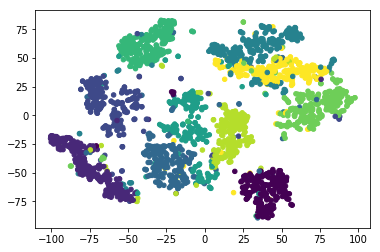

In [14]:
if __name__ == "__main__":
        print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
        print("Running example on 2,500 MNIST digits...")
        X = Math.loadtxt("mnist2500_X.txt")
        labels = Math.loadtxt("mnist2500_labels.txt")
        Y = tsne(X, 2, 50, 20.0)
        plt.scatter(Y[:,0], Y[:,1], 20, labels)
        plt.show()